In [30]:
import os
from skimage import io
import matplotlib.patches as patches
import cv2
import altair as alt
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [52]:
#input training labels (file and label)
train = pd.read_csv('train_labels.csv')
#putting labels as string for image generator
train['label'] = train['label'].astype(str)
train['id'] += '.tif'
# train['id'] = train['id'].apply(lambda x: 'train/' + x)
#creating random state to apply shuffling to data
train = shuffle(train, random_state = 42)


#sample_submission
sample = pd.read_csv('sample_submission.csv')

#creating test data frame to import data, creates id col with name of file
test = pd.DataFrame({'id':os.listdir('test')})

#setting batch size for entire project
batch_size = 64


In [53]:
#EDA
#check n and number of null's
print(train.info())

#simple stats for 'label' column
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220025 entries, 107796 to 121958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB
None


,id,label
count,220025,220025
unique,220025,2
top,d293308913e4a40cebb809d986aa9add65a76bfa.tif,0
freq,1,130908


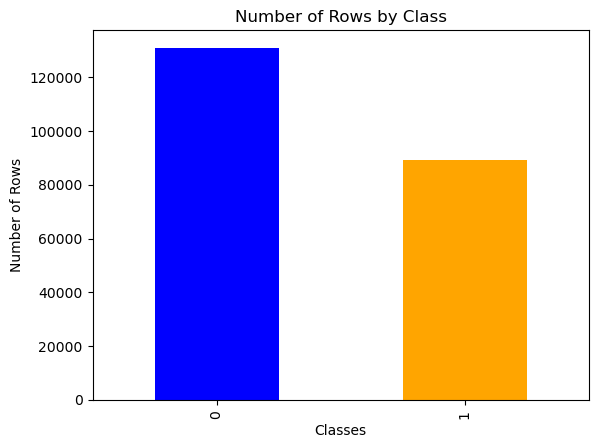

In [33]:
#chart for number for class
train['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Number of Rows by Class')
plt.xlabel('Classes')
plt.ylabel('Number of Rows')
plt.show()

In [34]:
# #Fixing over-sampling
# train_0 = train[train['label'] == '0']
# train_1 = train[train['label'] == '1']
# train_1_over = train_1.sample(train_0.shape[0], replace=True)
# train_concat = pd.concat([train_0, train_1_over])

# #chart for number for class
# train['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
# plt.title('Number of Rows by Class')
# plt.xlabel('Classes')
# plt.ylabel('Number of Rows')
# plt.show()

In [35]:
# #Saw that one file is simply a black image
# bad_file = train_concat['id'].iloc[0]
# train_concat.drop(train_concat[train_concat['id'] == bad_file].index, inplace = True)

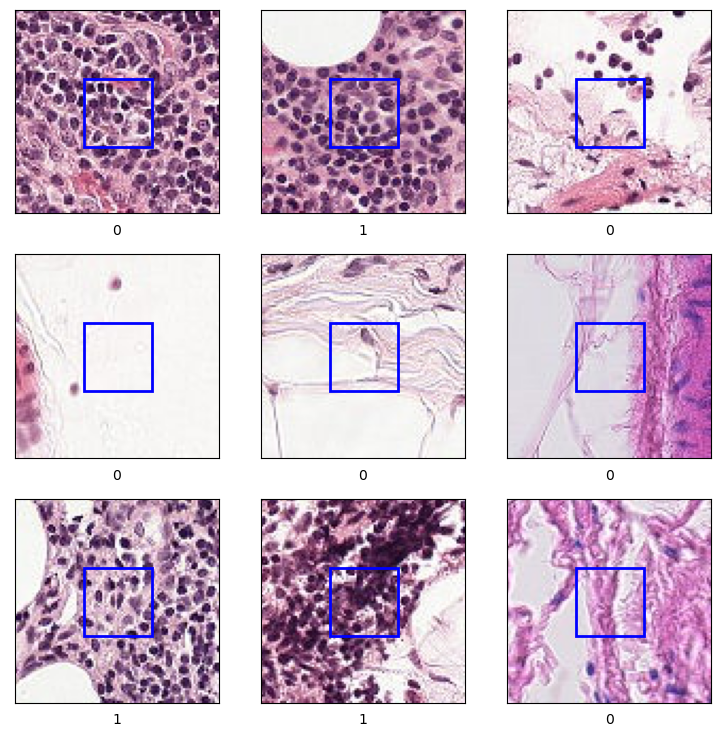

In [36]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i, axis in enumerate(ax.flat):
    file = str('train/' + str(train_concat['id'].iloc[i]))
    image = io.imread(file)
    axis.imshow(image)
    box = patches.Rectangle((32,32),32,32, linewidth=2, edgecolor='b',facecolor='none', linestyle='-')
    axis.add_patch(box)
    axis.set(xticks=[], yticks=[], xlabel = train.label[i]);

In [37]:
# x = layers.GlobalAveragePooling2D()(x)
#####ADD this layer instead of flatten?


In [54]:
#split this into training and validation for model
train, valid = train_test_split(train, test_size = 0.25)

In [59]:
#creating method to generate training and validation images
#creates validation set of 0.2 size of training data and scales pixels
generator_data = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.2
)


#getting image generator based upon labels in train df
train_generator = generator_data.flow_from_dataframe(
    dataframe = train,
    directory = 'train',
    x_col = 'id',
    y_col = 'label',
    shuffle = True,
    featurewise_std_normalization = True,
    class_mode = 'binary',
    batch_size = batch_size,
    random_state = 42,
    target_size = (64, 64)
)

#getting image generator based upon lables in valid df
valid_generator = generator_data.flow_from_dataframe(
    dataframe = valid,
    directory = 'train',
    x_col = 'id',
    y_col = 'label', 
    shuffle = True,
    featurewise_std_normalization = True,
    class_mode = 'binary',
    batch_size = batch_size,
    random_state = 42,
    target_size = (64, 64)
)

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


In [40]:
train_concat['label'] = train_concat['label'].astype(str)

In [60]:
#CNN Model


model = Sequential([
    Conv2D(16, kernel_size = (3,3), input_shape = (64,64,3), activation = 'relu'),
    Conv2D(16, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    Flatten(),
#     Dense(16, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
model.summary()


#sgd optimizer
opt = Adam(
    lr = 0.001,
    amsgrad=True
)

#learning rate scheduler for improved speed
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

#callback to run learning rate scheduler
callback = LearningRateScheduler(scheduler)

#early stopping
early_stopping = EarlyStopping(patience=2)

#ROC 
ROC = AUC()

#model compiler
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', ROC])

#fitting the model
model.fit(
    train_generator,
    validation_data = valid_generator,
    batch_size = batch_size,
    epochs = 10,
    callbacks = [callback, early_stopping],
)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 conv2d_83 (Conv2D)          (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_26 (Bat  (None, 30, 30, 16)       64        
 chNormalization)                                                
                                                                 
 dropout_22 (Dropout)        (None, 30, 30, 16)        0         
                                                                 
 conv2d_84 (Conv2D)          (None, 28, 28, 64)      

/Users/sam/miniconda3/envs/data_science/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-02-14 18:19:55.579851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2579/2579 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8291 - auc_7: 0.8993

2023-02-14 18:20:59.851654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2579/2579 [==============================] - 83s 32ms/step - loss: 0.3913 - accuracy: 0.8291 - auc_7: 0.8993 - val_loss: 0.3820 - val_accuracy: 0.8375 - val_auc_7: 0.9121 - lr: 0.0010
Epoch 2/10
2579/2579 [==============================] - 80s 31ms/step - loss: 0.3269 - accuracy: 0.8603 - auc_7: 0.9308 - val_loss: 0.3187 - val_accuracy: 0.8647 - val_auc_7: 0.9406 - lr: 9.0484e-04
Epoch 3/10
2579/2579 [==============================] - 80s 31ms/step - loss: 0.2949 - accuracy: 0.8755 - auc_7: 0.9437 - val_loss: 0.5386 - val_accuracy: 0.8030 - val_auc_7: 0.8674 - lr: 8.1873e-04
Epoch 4/10
2579/2579 [==============================] - 82s 32ms/step - loss: 0.2716 - accuracy: 0.8874 - auc_7: 0.9522 - val_loss: 0.3330 - val_accuracy: 0.8651 - val_auc_7: 0.9463 - lr: 7.4082e-04


In [61]:
data_generator_test = ImageDataGenerator(
    rescale = 1./255.,
)

#creating sequence of image generator
test_generator = data_generator_test.flow_from_dataframe(
    dataframe = test,
    directory ='test',
    x_col = 'id', 
    y_col = None,
    target_size = (64, 64),         
    batch_size = 1,
    shuffle = False,
    class_mode = None
)


#prediction
predict = model.predict(
    x = test_generator
)

Found 57458 validated image filenames.
   38/57458 [..............................] - ETA: 2:49 

2023-02-14 18:25:57.198463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57458/57458 [==============================] - 113s 2ms/step


In [62]:
# predict = np.transpose(predict)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predict))
submission_df.head()
submission_df.to_csv('sub.csv', index=False)
import kaggle
! chmod 600 /Users/sam/.kaggle/kaggle.json
! kaggle competitions submit -c histopathologic-cancer-detection -f sub.csv -m "CNN 2/14/11:06"

100%|███████████████████████████████████████| 2.36M/2.36M [00:06<00:00, 409kB/s]
Successfully submitted to Histopathologic Cancer Detection